## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

import torch

import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
from ML_helper import *

from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import h5py

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
h5f = h5py.File(('dataset.h5'), 'r')

num_samples, image_height, image_width = h5f['images'].shape
max_len = h5f['labels'].shape[1]

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [4]:
padding_token = 99


def preprocess_image(image, img_size):
    image = tf.convert_to_tensor(image)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image, label):
    # image = preprocess_image(image_path)
    # label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    batch_size=20
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [95]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model(lr = 1e-4):
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1.1",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2.1",
    )(x)
    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_height // 4), (image_width // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam(lr = lr)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 256, 32)  320         ['image[0][0]']                  
                                                                                                  
 Conv1.1 (Conv2D)               (None, 64, 256, 32)  9248        ['Conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 128, 32)  0           ['Conv1.1[0]

c:\Users\howards\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [96]:
batch_size=32

datause = 1

train_test_split = 0.85

idxs = np.arange(num_samples)

train_idxs = idxs[:int(len(idxs) * datause * train_test_split)]
test_idxs = idxs[int(len(idxs)*datause * train_test_split):]

train_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size, ctc=True)
val_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size, ctc=True)

In [97]:
validation_images = []
validation_labels = []

for batch in val_dl:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])


def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose=0)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [99]:
epochs = 40  # To get good results this should be at least 50.

model = build_model(lr =1e-4)
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_dl,
    validation_data=val_dl,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/40
25/25 [==============================] - 47s 2s/step - loss: 39.3529 - val_loss: 31.5618
Epoch 2/40
25/25 [==============================] - 50s 2s/step - loss: 22.2665 - val_loss: 19.3862
Epoch 3/40
25/25 [==============================] - 61s 2s/step - loss: 17.7812 - val_loss: 16.4794
Epoch 4/40
25/25 [==============================] - 51s 2s/step - loss: 15.9158 - val_loss: 15.1352
Epoch 5/40
25/25 [==============================] - 59s 2s/step - loss: 14.9007 - val_loss: 14.4034
Epoch 6/40
25/25 [==============================] - 53s 2s/step - loss: 14.3251 - val_loss: 13.9423
Epoch 7/40
25/25 [==============================] - 59s 2s/step - loss: 13.9288 - val_loss: 13.5877
Epoch 8/40
25/25 [==============================] - 52s 2s/step - loss: 13.6490 - val_loss: 13.3725
Epoch 9/40
25/25 [==============================] - 58s 2s/step - loss: 13.4501 - val_loss: 13.1314
Epoch 10/40
25/25 [==============================] - 56s 2s/step - loss: 13.2462 - val_loss: 12.9540

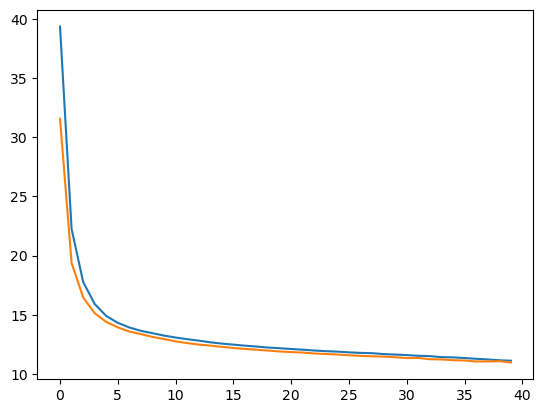

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 321ms/step


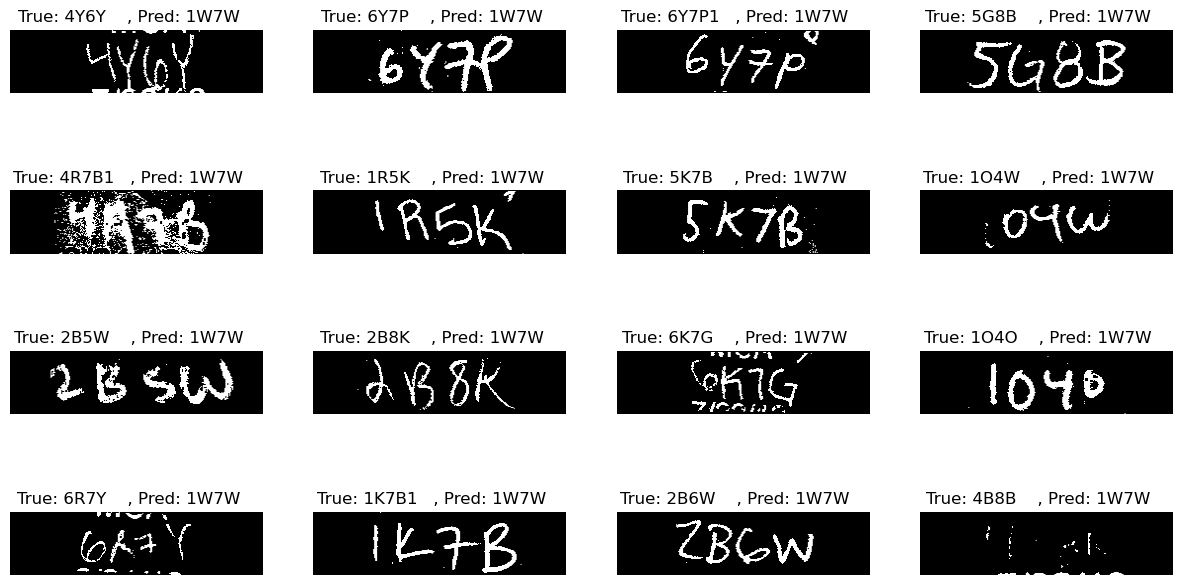

In [101]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def decode_vectorized_label(results):

    # results = np.argmax(results,axis=2)
    # results[results==0] = 1
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text


#  Let's check results on some test samples.
batch = train_dl[0]
batch_images = batch["image"]
batch_labels = batch["label"]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(preds)
true_texts = decode_vectorized_label(batch_labels)


for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"True: {true_texts[i].split('[')[0]}, Pred: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()

1/1 [==============================] - 0s 314ms/step


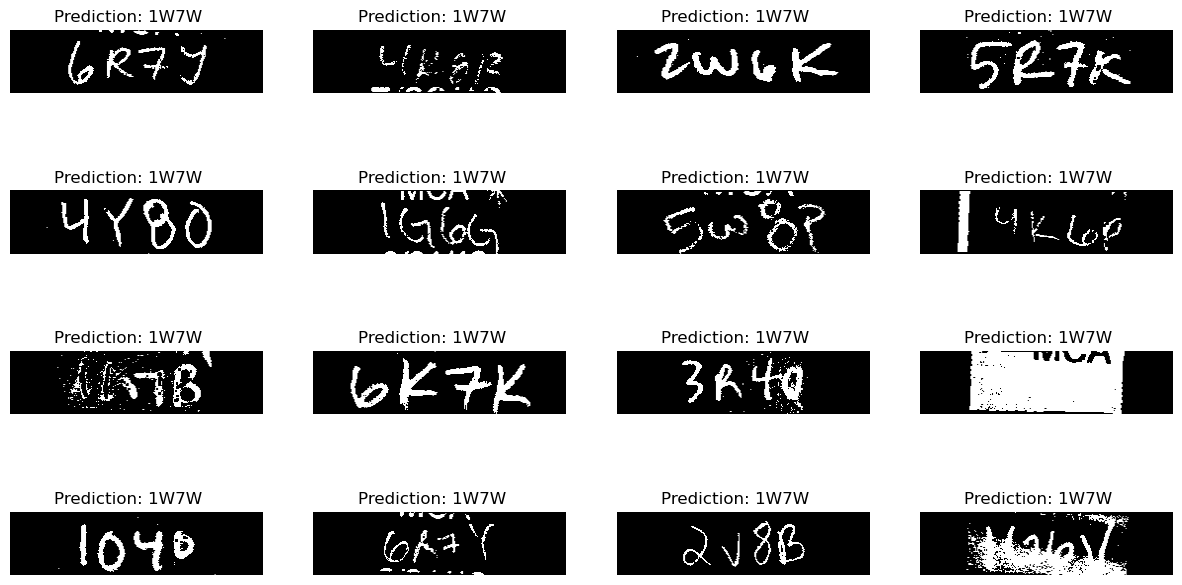

In [102]:
#  Let's check results on some test samples.
batch = val_dl[0]
batch_images = batch["image"]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(preds)

for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
